In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocess import Pool, cpu_count

from fem2D import *
from simpleMeshes import *

nprocesses = cpu_count()
print(f"Code parallelized with {nprocesses} processes.")

Code parallelized with 12 processes.


In [3]:
# construction du maillage

eraseCurrentMesh()

N = 4       # elements order

Lx = 100000.0   # square size
Lz = 4*Lx
dx = Lx/5   # elements size
elements, nodes = rectangleMesh(Lx,Lz,dx,N, botTop=False)
Δx = dx/(N+1)

dof = len(nodes)
print(f"{dof=}")

dof=2025


<AxesSubplot:>

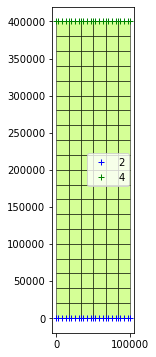

In [4]:
plotMesh(elements, nodes, [2, 4])

In [5]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points
xi,w,dh = readGLL(N)
print(f"{xi=}")

xi=array([-1.        , -0.65465367,  0.        ,  0.65465367,  1.        ])


In [6]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne
# La transformation depuis un élément quelconque vers l'élément de référence est l'interpolation bilinéaire

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

def computeJacobian(e):
        
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N+1,N+1))
    Je21 = np.zeros((N+1,N+1))
    Je12 = np.zeros((N+1,N+1))
    Je22 = np.zeros((N+1,N+1))
    
    e.detJ = np.zeros((N+1,N+1))
    
    e.iJe11 = np.zeros((N+1,N+1))
    e.iJe21 = np.zeros((N+1,N+1))
    e.iJe12 = np.zeros((N+1,N+1))
    e.iJe22 = np.zeros((N+1,N+1))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    
    for i in range(N+1):
        for j in range(N+1):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.iJe11[i,j] =  Je22[i,j]/e.detJ[i,j]
            e.iJe22[i,j] =  Je11[i,j]/e.detJ[i,j]
            e.iJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.iJe12[i,j] = -Je12[i,j]/e.detJ[i,j]
            
    return e
    
with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeJacobian, elements), total=len(elements)))

100%|██████████| 120/120 [00:00<00:00, 438.99it/s]


In [7]:
# paramètres mécaniques béton

E = 30e9        # module d'Young
ν = 0.25        # coefficient de Poisson

# paramètres de Lamé
λ = (E*ν) / ((1+ν)*(1-2*ν))
μ = E / (2*(1+ν))

# masse volumique
ρ = 2500.0

# vitesses d'ondes
vp = np.sqrt((λ+2*μ)/ρ)
vs =np.sqrt(μ/ρ)

print(f"Vitesse des ondes P : {vp/1000:.3f}km/s")
print(f"Vitesse des ondes S : {vs/1000:.3f}km/s")


Vitesse des ondes P : 3.795km/s
Vitesse des ondes S : 2.191km/s


In [8]:
# calcul des matrices élémentaires

δ = np.eye(N+1)

def computeStiffnes(e):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Ke = np.zeros((2*(N+1)**2,2*(N+1)**2))
    
    Kdxdx = np.zeros((N+1,N+1,N+1,N+1))
    Kdydy = np.zeros((N+1,N+1,N+1,N+1))
    Kdxdy = np.zeros((N+1,N+1,N+1,N+1))
    Kdydx = np.zeros((N+1,N+1,N+1,N+1))
    
    for a in range(N+1):
        for b in range(N+1):
            for c in range(N+1):
                for d in range(N+1):
                       
                        for p in range(N+1):
                            for q in range(N+1):
                                
                                Kdxdx[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe11[p,q]*dh[c,p]*δ[d,q] + e.iJe12[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydy[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdxdy[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydx[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                
    for i in range(2*(N+1)**2):
        for j in range(2*(N+1)**2):
            
            a,b = i//2//(N+1), i//2%(N+1)
            c,d = j//2//(N+1), j//2%(N+1)
            
            if i%2 == 0 and j%2 == 0:
                
                e.Ke[i,j] = (2*λ+μ)*Kdxdx[a,b,c,d] + μ*Kdydy[a,b,c,d]             
                
            if i%2 == 0 and j%2 != 0:
                
                e.Ke[i,j] = λ*Kdxdy[a,b,c,d] + μ*Kdydx[a,b,c,d]      
            
            if i%2 != 0 and j%2 == 0:
                
                e.Ke[i,j] = λ*Kdydx[a,b,c,d] + μ*Kdxdy[a,b,c,d]             
                
            if i%2 != 0 and j%2 != 0:
                
                e.Ke[i,j] = (2*λ+μ)*Kdydy[a,b,c,d] + μ*Kdxdx[a,b,c,d] 
                                
    return e

# elements = list(tqdm(map(computeStiffnes, elements), total=len(elements)))

with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeStiffnes, elements), total=len(elements)))

100%|██████████| 120/120 [00:03<00:00, 34.68it/s]


In [9]:
# calcul des matrices élémentaires de masse

for e in tqdm(elements):
    
    e.Me = np.zeros(2*(N+1)**2) # diagonal
    
    for i in range(2*(N+1)**2):
        e.Me[i] = ρ * w[i//2//(N+1)]*w[i//2%(N+1)]*e.detJ[i//2//(N+1),i//2%(N+1)]


100%|██████████| 120/120 [00:00<00:00, 11090.42it/s]


In [57]:
# assemblage

K = np.zeros((2*dof,2*dof))
M = np.zeros(2*dof)

for e in tqdm(elements):
    for (i,n1) in enumerate(e.nodes):
        M[2*n1.id] += e.Me[2*i]
        M[2*n1.id+1] += e.Me[2*i+1]
        for (j,n2) in enumerate(e.nodes):
            K[2*n1.id,2*n2.id] += e.Ke[2*i,2*j]
            K[2*n1.id+1,2*n2.id] += e.Ke[2*i+1,2*j]
            K[2*n1.id,2*n2.id+1] += e.Ke[2*i,2*j+1]
            K[2*n1.id+1,2*n2.id+1] += e.Ke[2*i+1,2*j+1]

100%|██████████| 120/120 [00:00<00:00, 320.50it/s]


In [58]:
# définition source : sinus en cisaillement au niveau du sol : cond Dirichlet

nodesBot1 = []
nodesBot2 = []
otherNodes = []
for n in nodes:
    if n.region == 2:
        nodesBot1.append(2*n.id)
        nodesBot2.append(2*n.id+1)
    else:
        otherNodes.append(2*n.id)
        otherNodes.append(2*n.id+1)
        

In [59]:
# on déplace les noeuds en condition de Dirchlet en haut

for i,n in enumerate(nodesBot1):
    K[:,i],K[:,n] = K[:,n],K[:,i]
    M[i],M[n] = M[n],M[i]
    K[i,:] = 0
    K[i,i] = 1
for j,n in enumerate(nodesBot2):
    i = j+len(nodesBot1)-1
    K[:,i],K[:,n] = K[:,n],K[:,i]
    M[i],M[n] = M[n],M[i]
    K[i,:] = 0
    K[i,i] = 1

In [61]:
%matplotlib tk
kmax = max(K.max(), -K.min())
plt.imshow(K, cmap="seismic", vmin=-kmax, vmax=kmax)

In [60]:
# inverting mass matrix
iM = 1/M

In [62]:
# résolution temporelle

Nit = 500
cfl = 0.25
Δt = Δx/vp* cfl
T = Δt*Nit 

time = np.linspace(0,T,Nit)

U = np.zeros((Nit, 2*dof))
dU = np.zeros((Nit, 2*dof))
ddU = np.zeros((Nit, 2*dof))

f0 = vs/(5*Δx)     # tuning

In [63]:
# tests sur valeurs paramètres
print(f"CFL = {Δt/Δx*vp}")
print(f"Δx = {Δx}m while λmin ~ {vs/(4*f0)}")

CFL = 0.25000000000000006
Δx = 4000.0m while λmin ~ 5000.0


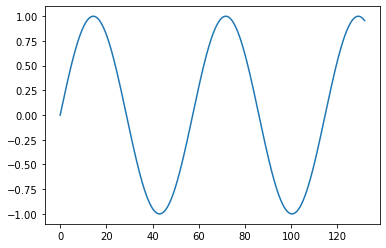

In [64]:
%matplotlib inline
plt.plot(time, np.sin(f0*time))

In [67]:
A = [1,2,3,4,5]
A[2:4]

[3, 4]

In [65]:
# FD

Dbc = len(nodesBot1) + len(nodesBot2)

for i in tqdm(range(2,Nit)):
    # boundary conditions
    U[i,:len(nodesBot1)] = np.sin(f0*i*Δt)
    # simple time scheme
    U[i,Dbc:] = 2*U[i-1,Dbc:] - U[i-2,Dbc:] - Δt**2*np.multiply(iM , K@U[i-1,:])[Dbc:]


100%|██████████| 498/498 [00:19<00:00, 25.51it/s]


In [40]:
import matplotlib.animation as animation

# %matplotlib widget
%matplotlib tk

In [41]:
%matplotlib tk
fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

it = 1000

plotDeformedMesh(elements, U[it,:], ax, 1e4)

IndexError: index 1000 is out of bounds for axis 0 with size 500

In [66]:
%matplotlib tk

fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

# plotMeshLimits(elements, ax)

U1 = U[:1000,:]

dtot = np.sqrt(U1[:,::2]**2 + U1[:,1::2]**2)

dmin = min(dtot.min(), -dtot.max())/3
dmin = 1.0

dots = ax.scatter([n.x for n in nodes], [n.y for n in nodes], c=dtot[0,:], zorder=4, cmap="seismic", vmin=dmin, vmax=-dmin)

cbar = plt.colorbar(dots)
ttl = ax.annotate("it = 0", xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='grey'), zorder=5)

dit = 10

def animate(i):
    dots.set_array(dtot[dit*i,:])
    cbar.update_normal(dots)
    ttl.set_text(f"it = {dit*i}")
    return dots,ttl,

ani = animation.FuncAnimation(fig, animate, interval=300, blit=True, frames = int(Nit/dit))

ani.event_source.start()

plt.show()